In [104]:
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import sklearn.model_selection as model_sel
import datetime as dt 
import matplotlib.pyplot as plt

In [105]:
gas_hr=pd.read_csv('hourly_readings_final.csv');
gas_cor=pd.read_csv('top_correlated_households.csv');
gas_hr=gas_hr[gas_hr.dataid!=6101]

In [106]:
gas_hr.localminute = pd.to_datetime(gas_hr.localminute, infer_datetime_format = True,format = "%Y/%m/%d %I:%M:%S %p");
ori_gas_hr=gas_hr;
min_time=min(gas_hr['localminute']);
gas_hr.localminute=gas_hr.localminute.map(lambda x: (x-min_time).total_seconds()/3600.0);


In [78]:
id_list=gas_hr['dataid'].unique()


In [79]:
normed_gas_hr=pd.DataFrame();
for _id in id_list:
    gas_temp=gas_hr[gas_hr['dataid']==_id];
    min_consumption=min(gas_temp['meter_value']);
    gas_temp['meter_value']=gas_temp.meter_value.map(lambda x: x-min_consumption);
    normed_gas_hr=normed_gas_hr.append(gas_temp);


/Users/Anvy/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [80]:
id_lack=[]
length=[]
id_list1=[35];
for _id in id_list:
    gas_hr_id=gas_hr[gas_hr['dataid']==_id];
    length.append(len(gas_hr_id))
for index, item in enumerate(length):
    if((item<2000) & (item>100)):
        id_lack.append(id_list[index]);
id_lack

[1403,
 2755,
 2814,
 2946,
 3036,
 4671,
 5317,
 5545,
 6578,
 6673,
 7566,
 8244,
 9160,
 9600,
 9620]

In [81]:
id_lack1=[4671];
soft_margin=0.2;
threshold=0.9;
normed_gas_hr_cp=pd.DataFrame(columns=['localminute','dataid','meter_value'])
for _id in id_lack:
    gas_lack_hr=normed_gas_hr[normed_gas_hr['dataid']==_id];
    time_min=min(gas_lack_hr['localminute']);
    time_max=max(gas_lack_hr['localminute']);
    gas_compensate=normed_gas_hr[(normed_gas_hr['localminute']>=time_min) & (normed_gas_hr['localminute']<=time_max) 
                         &(normed_gas_hr['dataid']!=_id)];
    id_com=gas_compensate['dataid'].unique();
    
    for c_id in id_com:
        gas_cid=pd.DataFrame();
        gas_cid=gas_compensate[gas_compensate['dataid']==c_id];
        #c_diff=gas_cid['meter_value'].diff();
        min_consumption=min(gas_cid['meter_value']);
        gas_cid['meter_value']=gas_cid.meter_value.map(lambda x: x-min_consumption);
        gas_cid.reset_index(drop=True,inplace=True);
        
        time_min_c=min(gas_cid['localminute']);
        time_max_c=max(gas_cid['localminute']);
        gas_lack_c=pd.DataFrame();
        gas_lack_c=gas_lack_hr[(gas_lack_hr['localminute']>=time_min_c) & (gas_lack_hr['localminute']<=time_max_c)];
        #ori_diff=gas_lack_c['meter_value'].diff();
        min_consumption=min(gas_lack_c['meter_value']);
        gas_lack_c['meter_value']=gas_lack_c.meter_value.map(lambda x: x-min_consumption);
        gas_lack_c.reset_index(drop=True,inplace=True);
        
        diff_percent=gas_cid['meter_value']/gas_lack_c['meter_value'];
        equal_num=len(diff_percent[(diff_percent<=(1+soft_margin))&
                                   (diff_percent>=(1-soft_margin))])+len(diff_percent[np.isnan(diff_percent)]);
        if(equal_num>=threshold*len(gas_cid)):
            gas_cid.dataid=gas_cid.dataid.replace(c_id,_id);
            if(time_min_c!=time_min):
                temp_reading=gas_lack_hr[gas_lack_hr['localminute']==time_min_c]['meter_value'].values;
                extra_reading=temp_reading[0];
                gas_cid['meter_value']=gas_cid.meter_value.map(lambda x: x+extra_reading);
            normed_gas_hr_cp=normed_gas_hr_cp.append(gas_cid);
            
            

/Users/Anvy/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Anvy/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Anvy/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

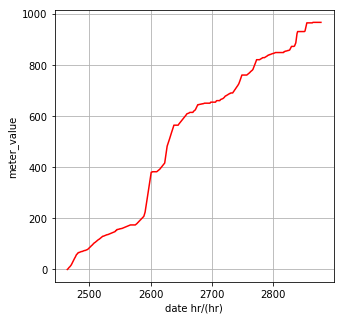

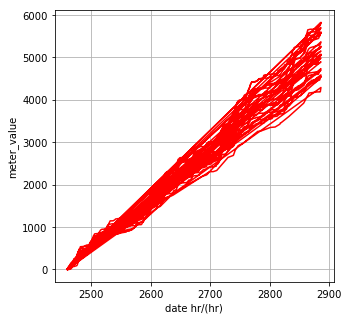

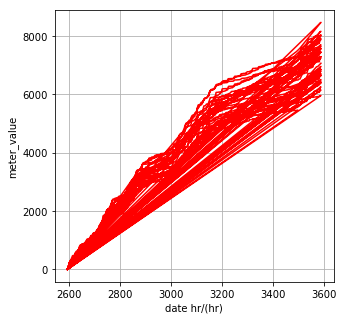

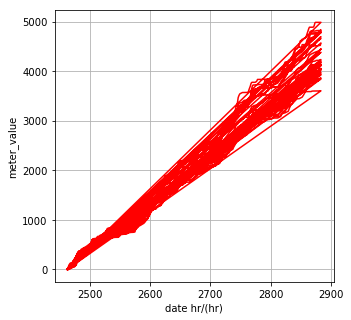

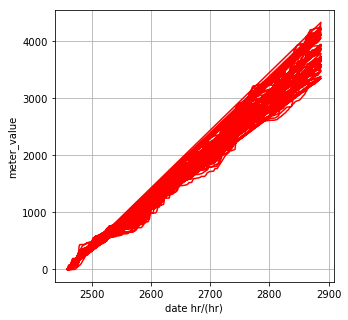

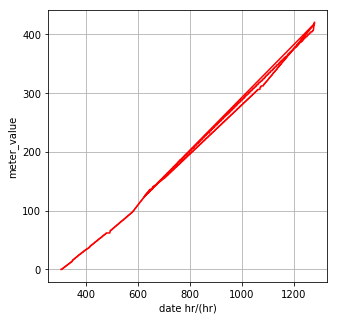

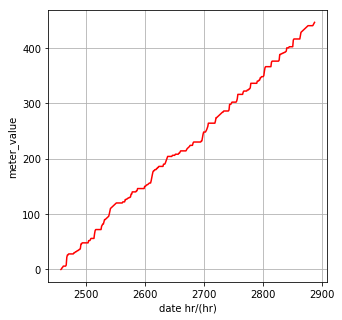

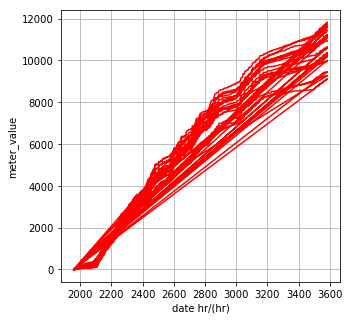

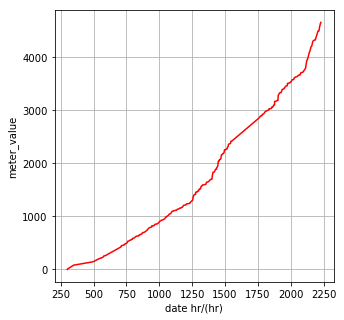

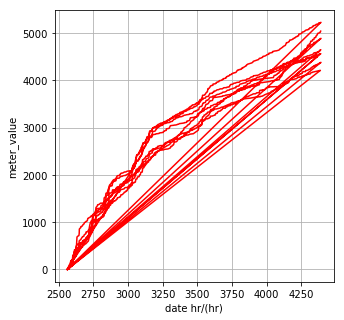

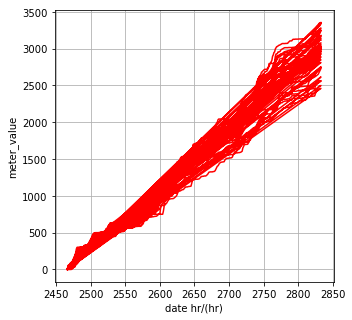

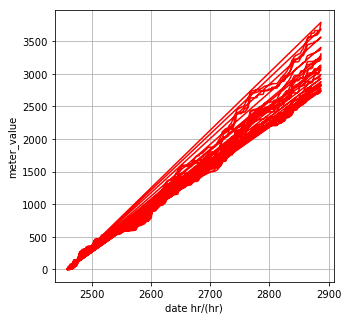

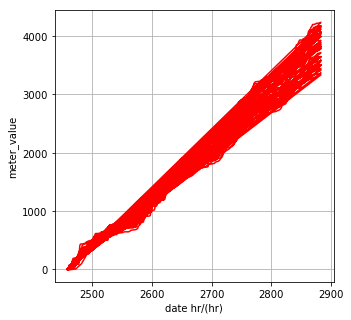

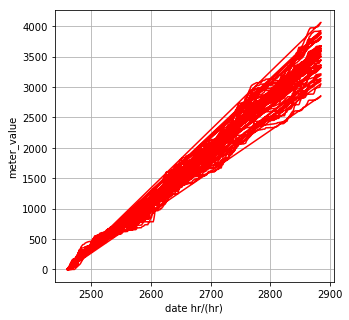

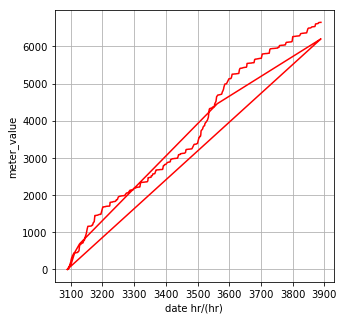

In [69]:
for _id in id_lack:
    temp=normed_gas_hr[normed_gas_hr['dataid']==_id]
    temp.reset_index(drop=True,inplace=True)
    fig=plt.figure(figsize=(5,5));
    plt.plot(temp.localminute,temp.meter_value,'r');
    plt.xlabel('date hr/(hr)');
    plt.ylabel('meter_value'),
    plt.grid();
    plt.show();

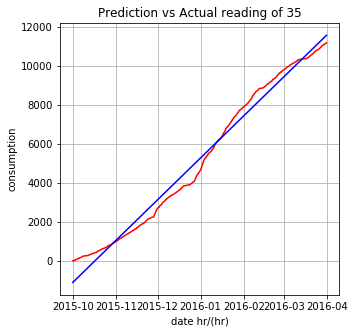

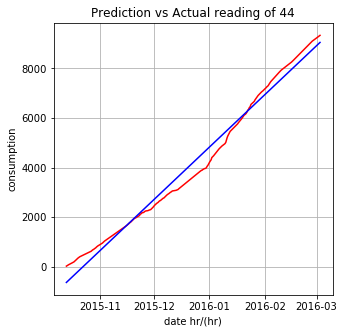

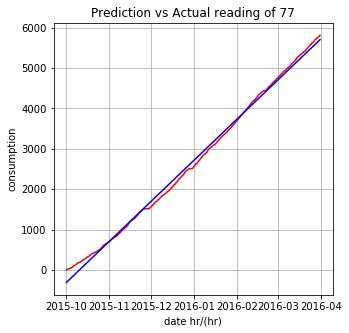

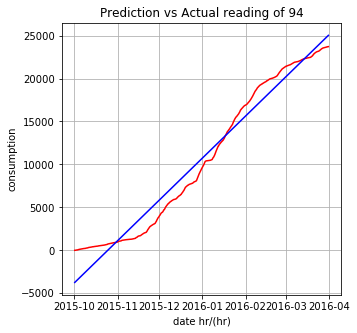

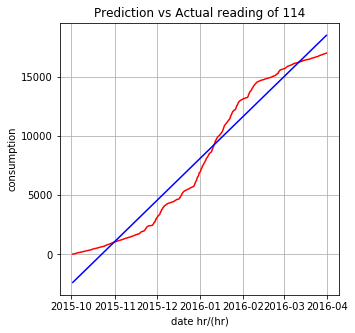

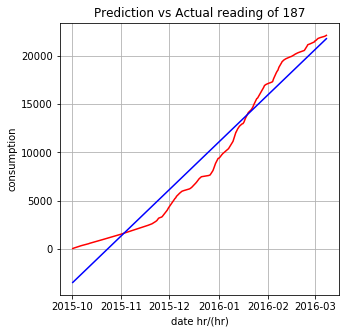

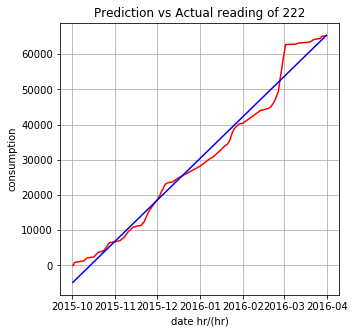

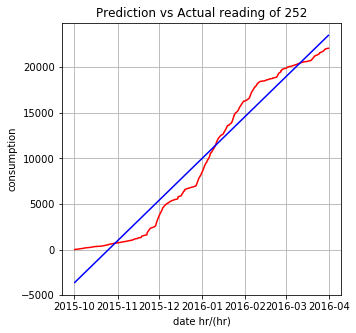

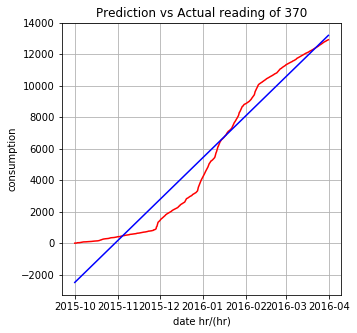

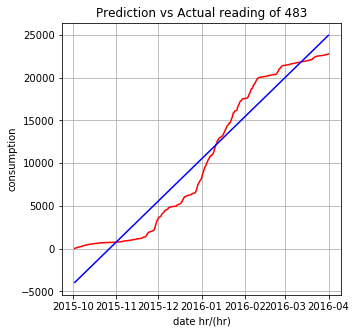

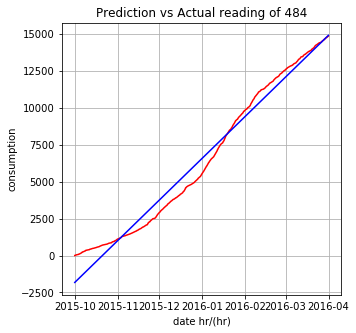

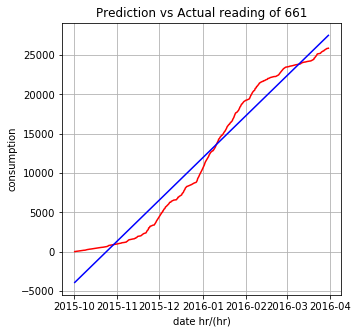

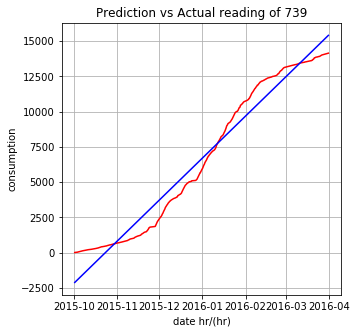

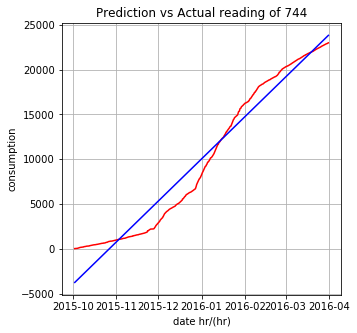

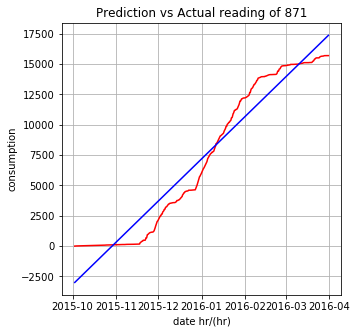

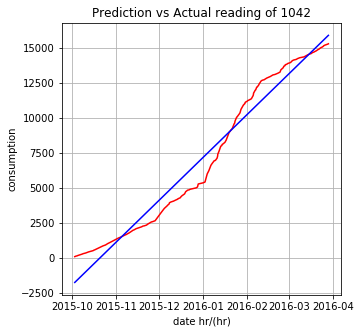

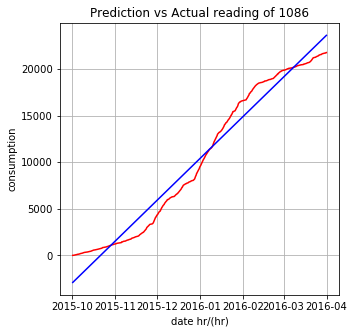

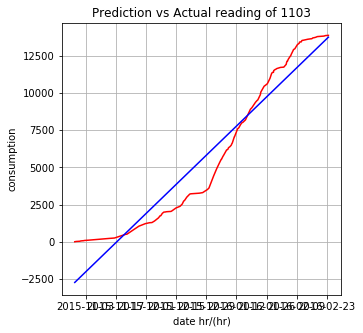

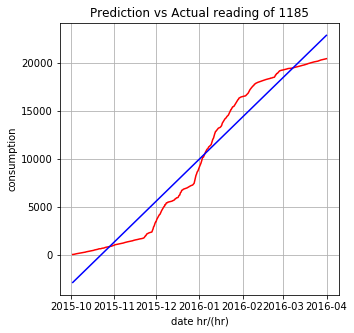

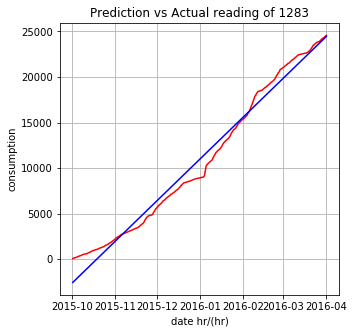

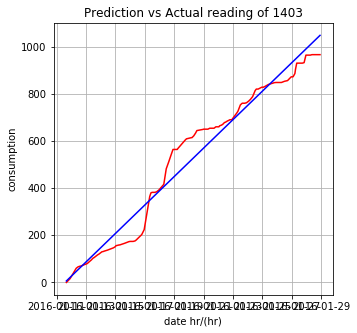

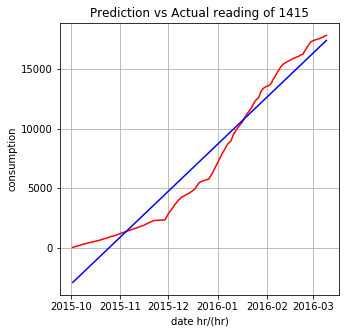

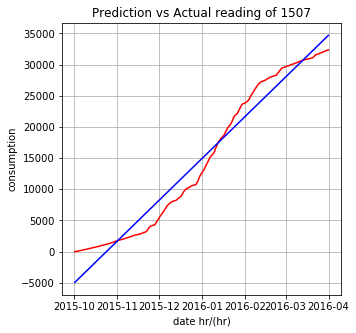

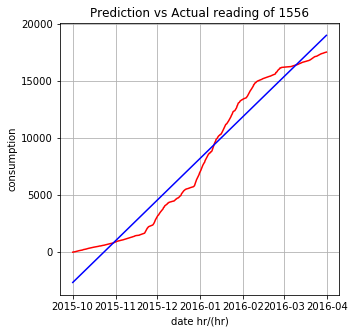

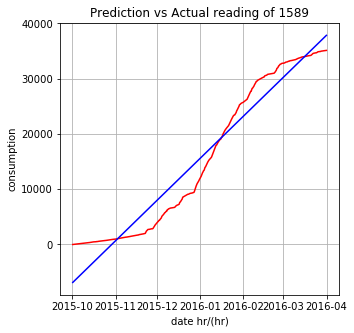

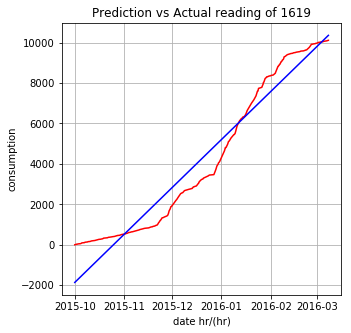

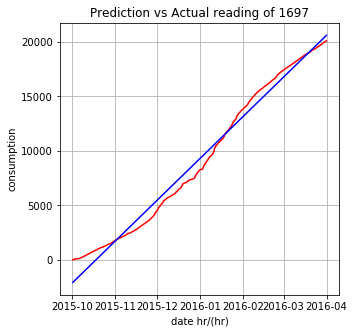

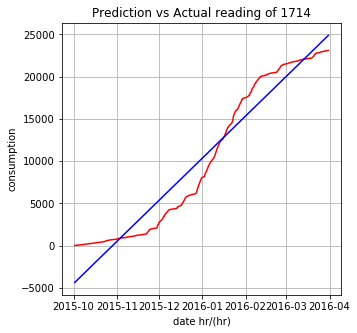

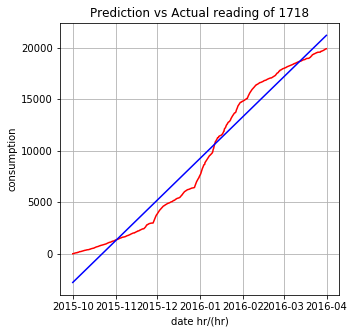

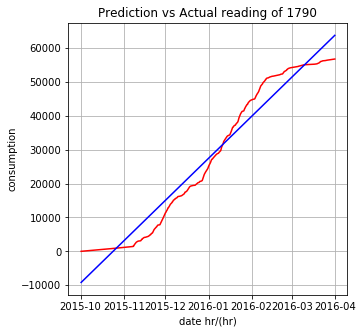

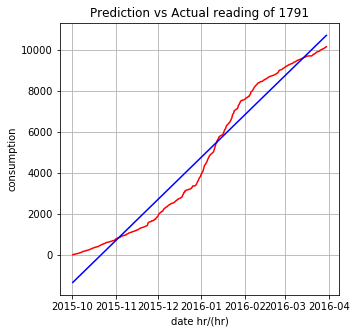

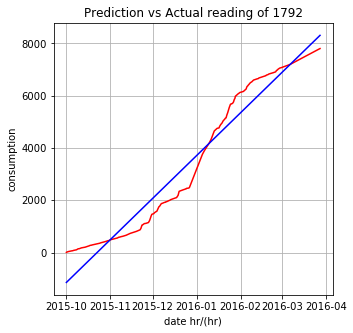

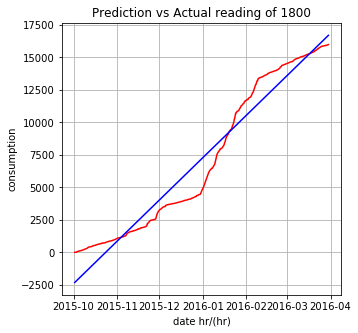

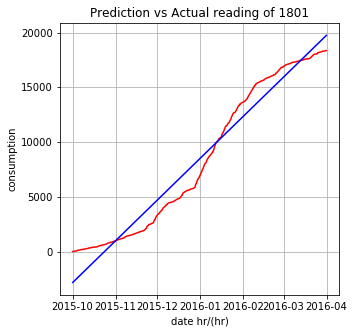

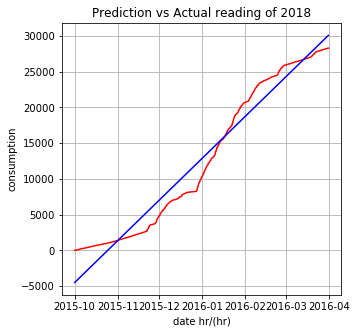

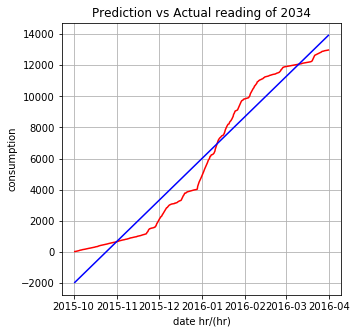

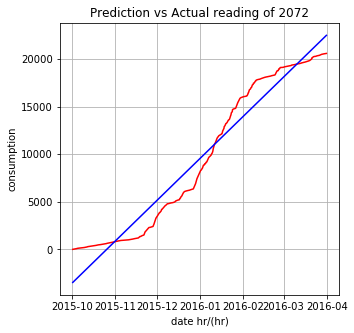

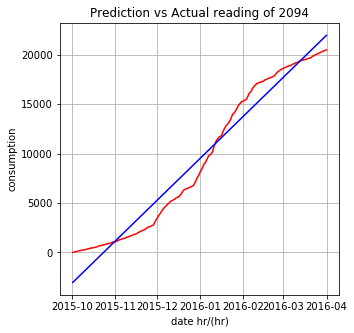

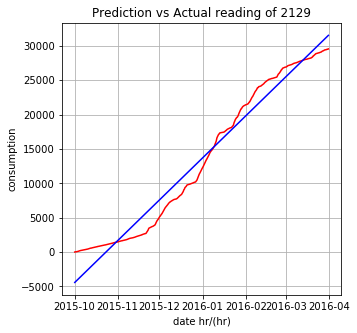

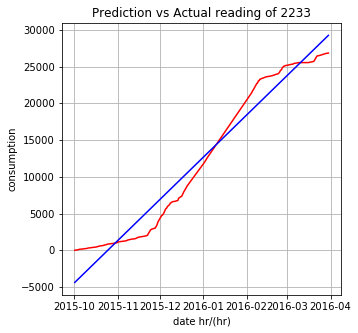

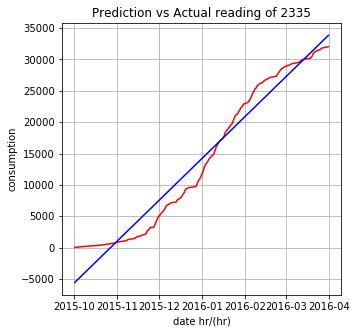

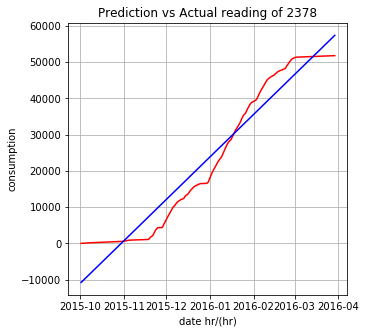

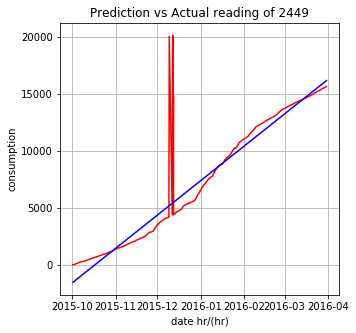

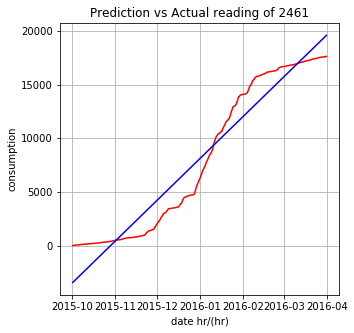

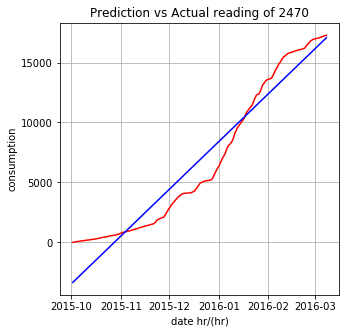

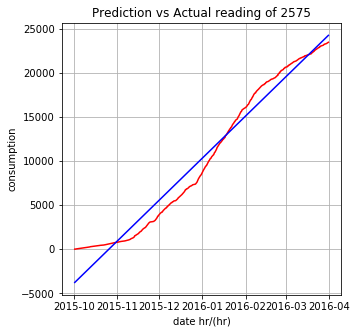

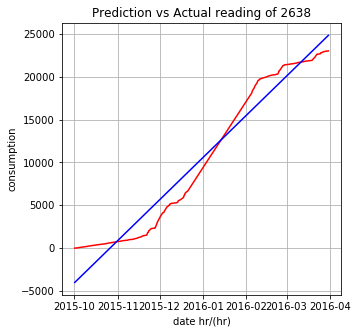

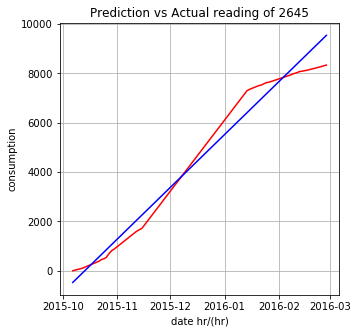

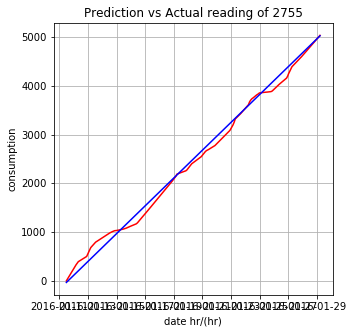

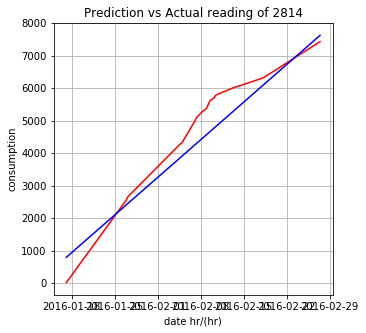

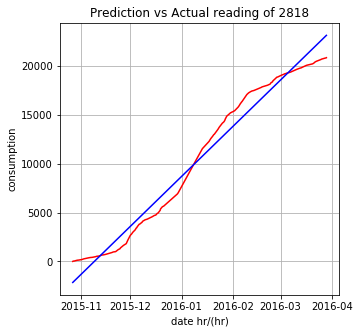

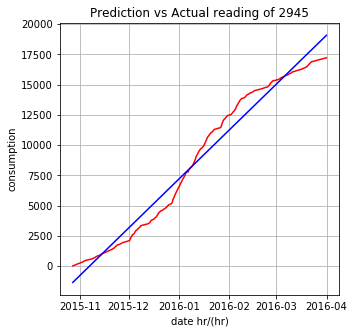

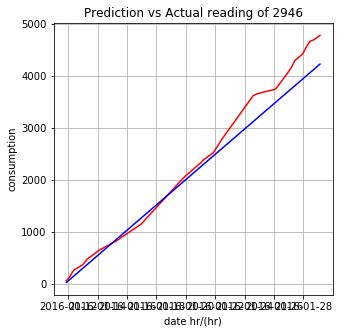

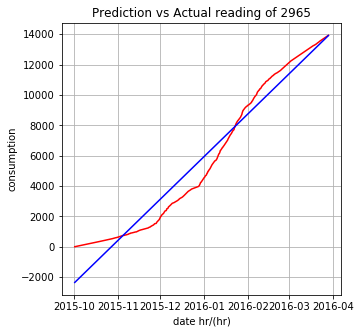

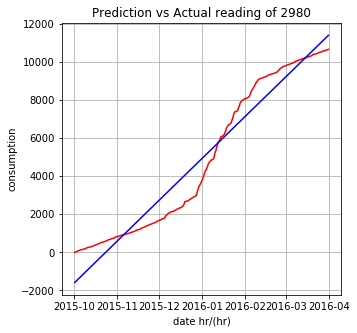

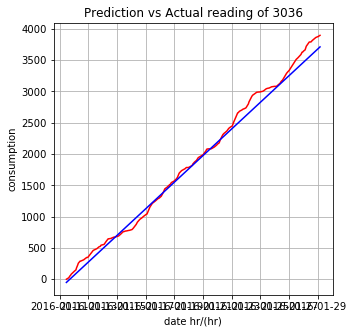

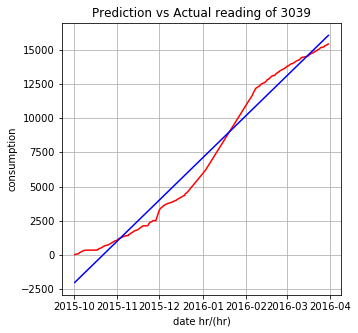

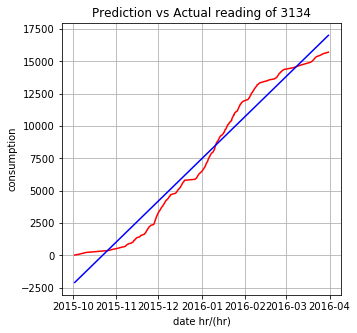

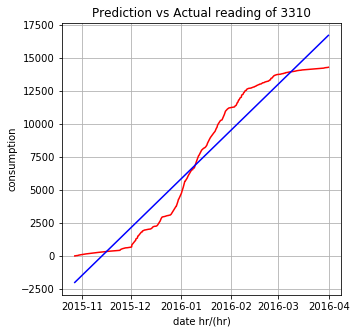

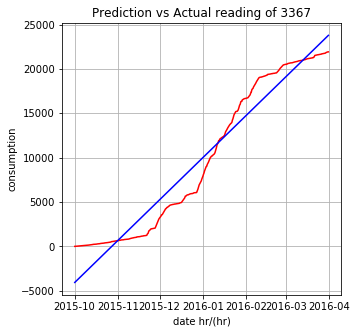

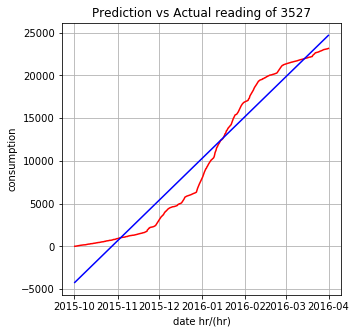

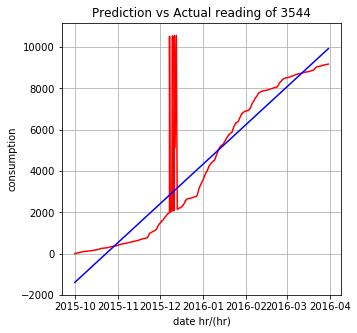

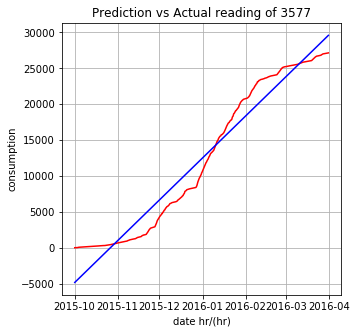

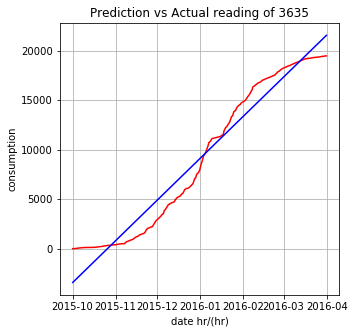

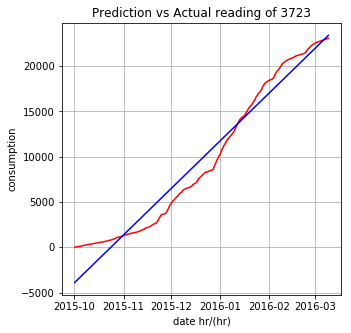

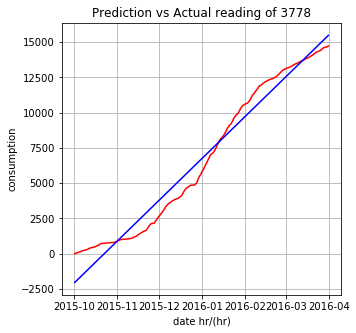

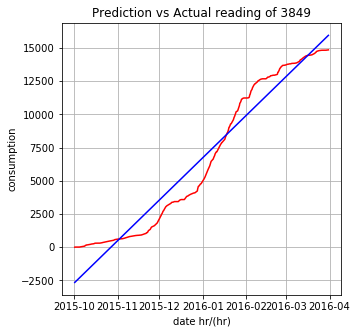

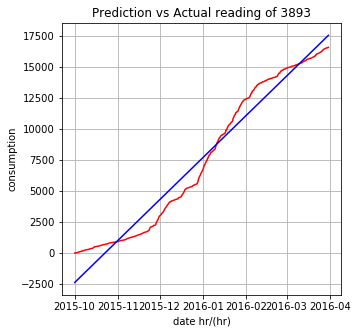

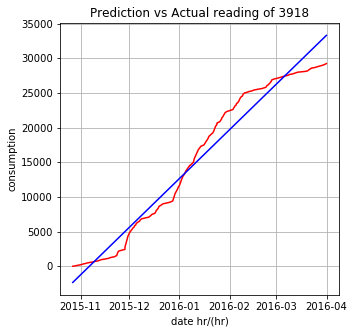

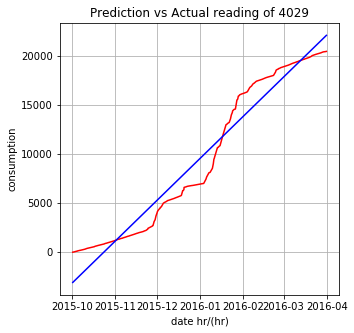

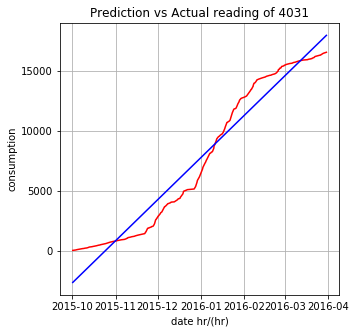

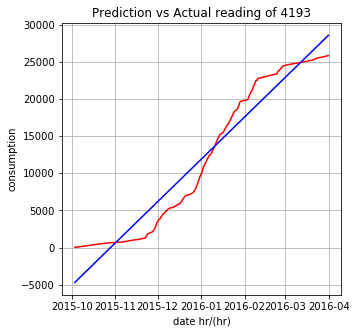

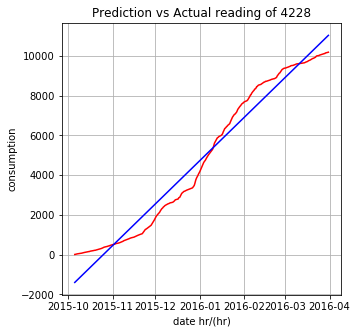

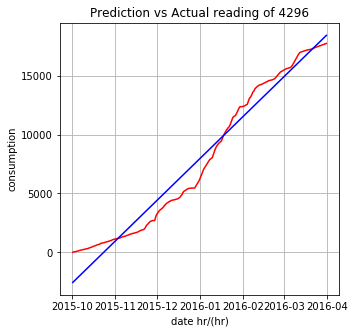

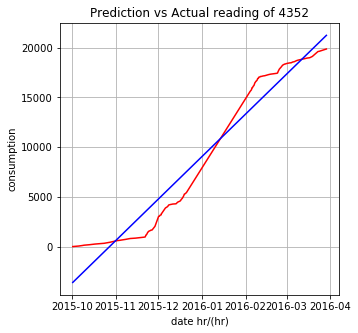

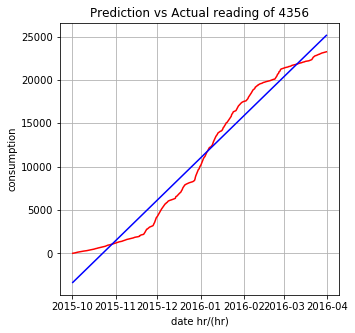

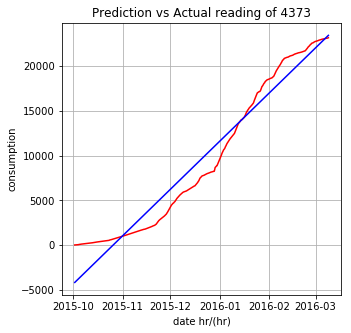

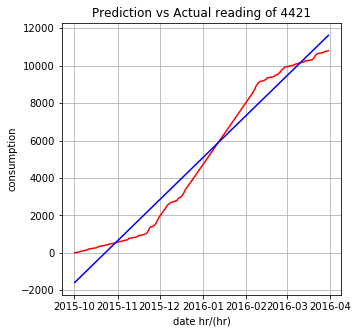

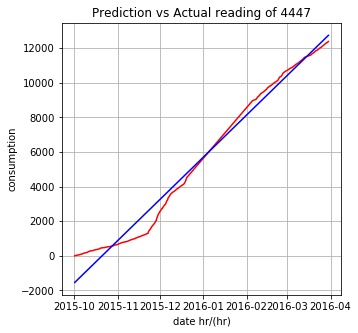

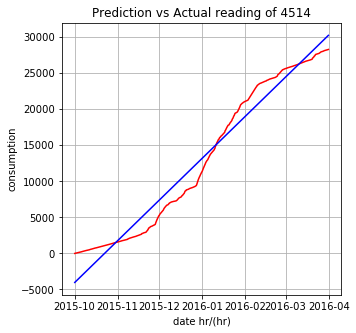

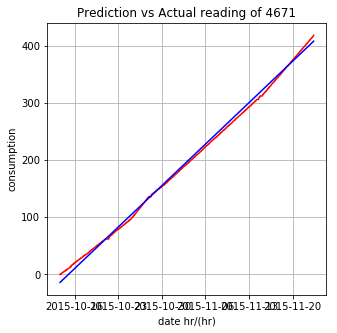

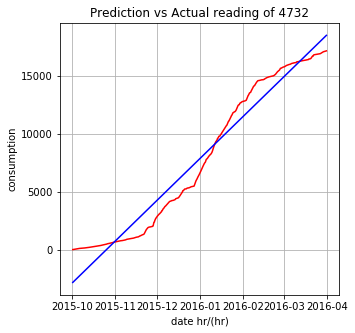

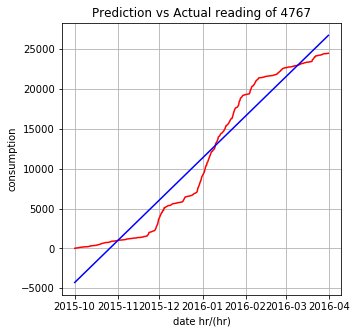

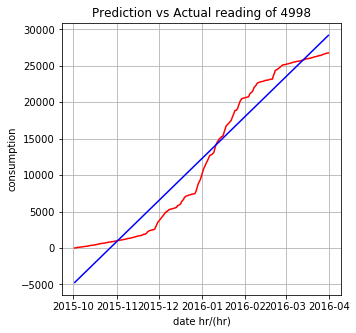

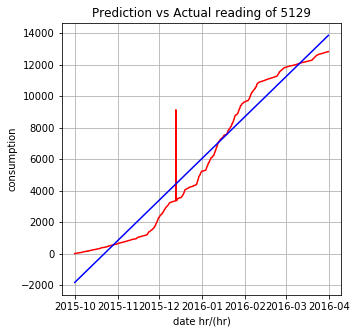

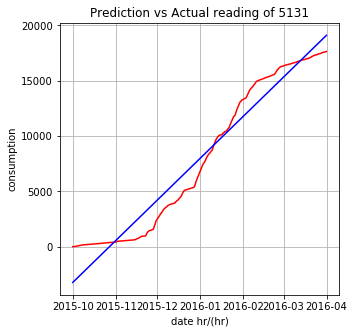

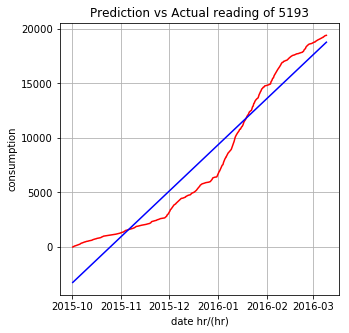

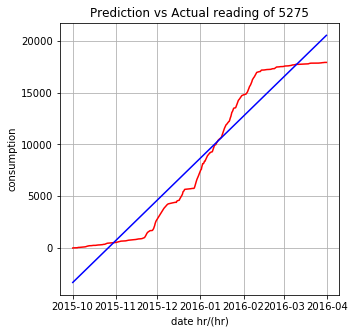

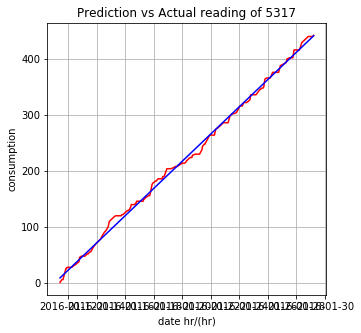

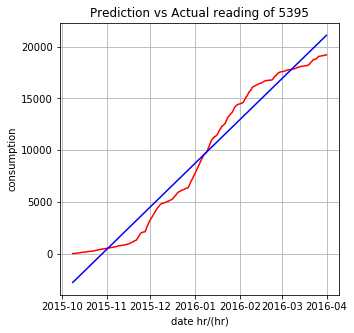

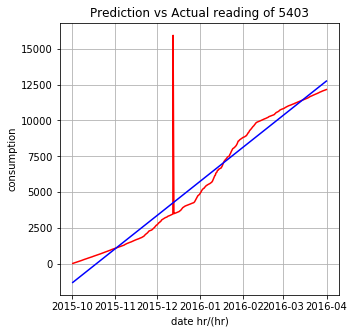

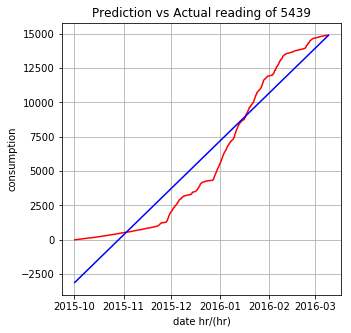

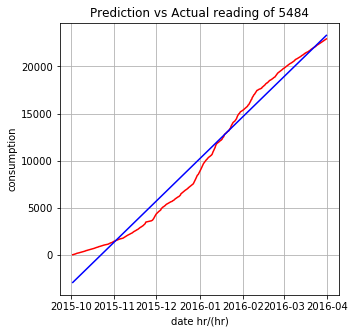

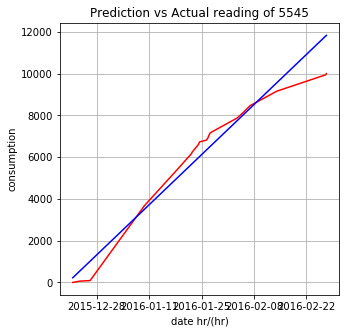

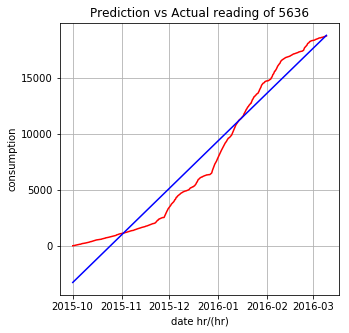

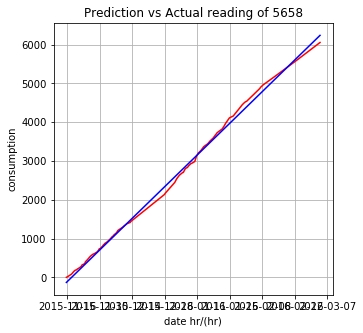

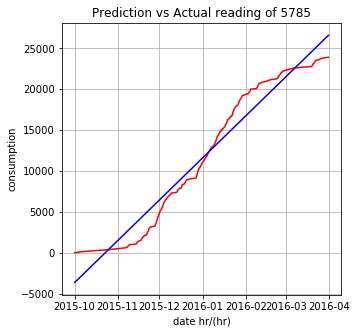

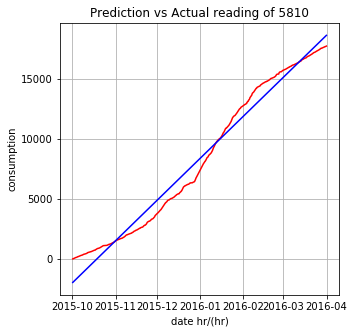

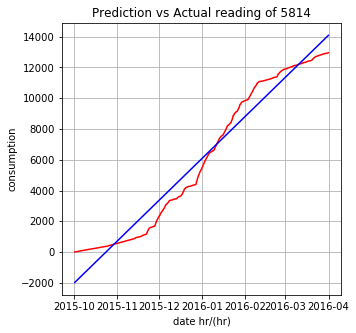

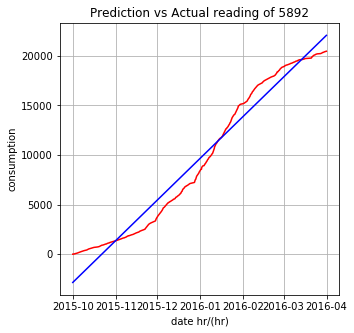

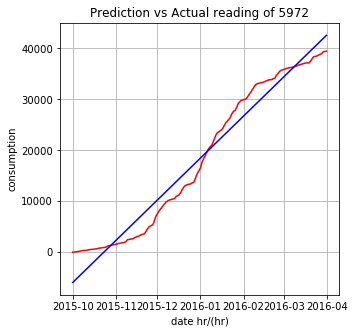

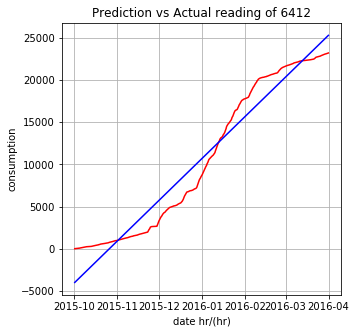

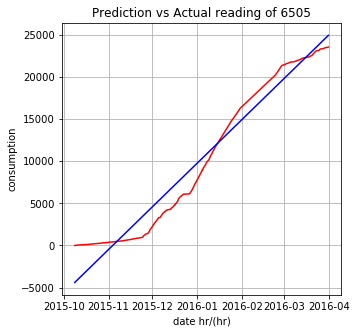

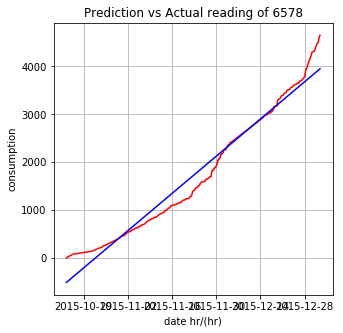

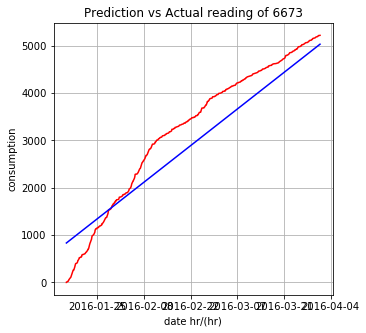

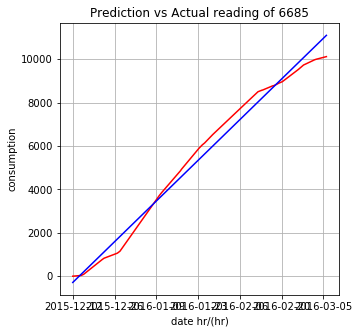

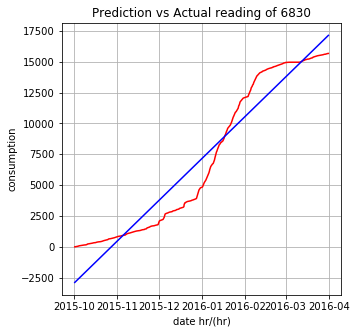

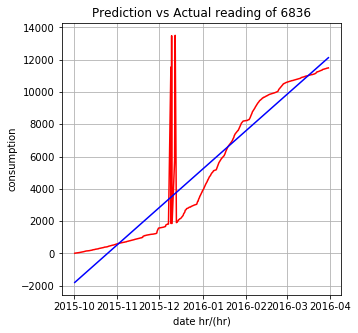

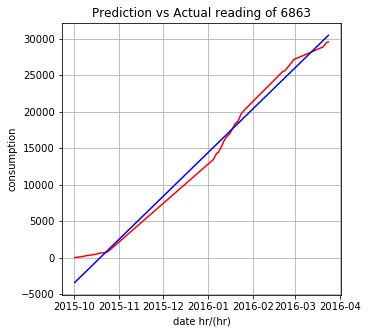

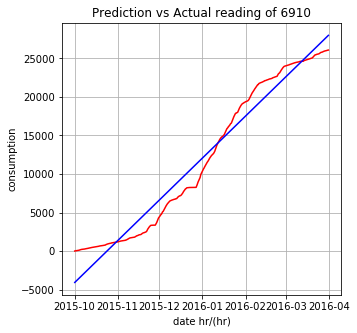

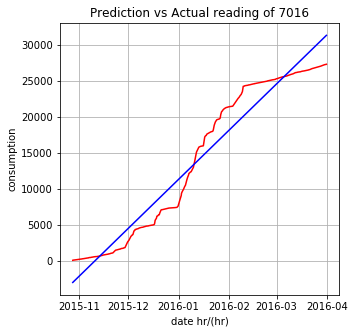

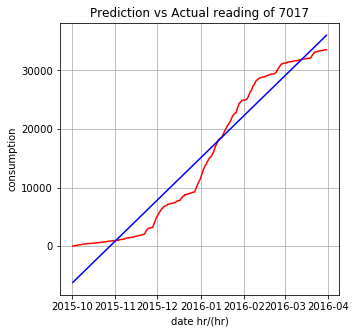

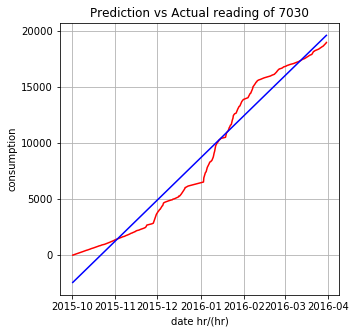

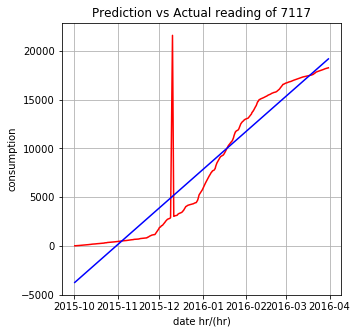

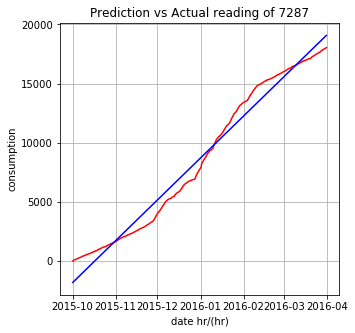

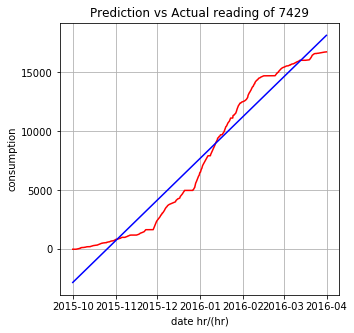

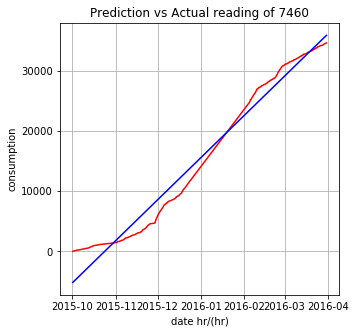

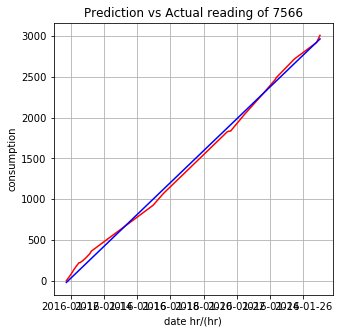

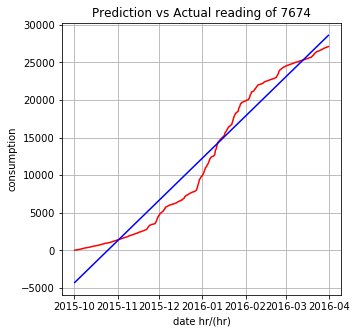

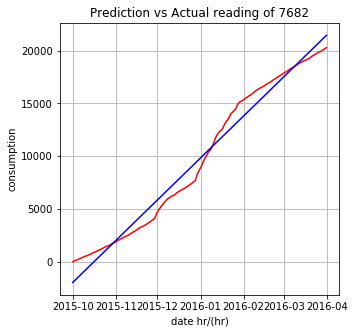

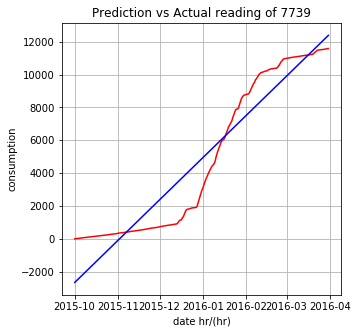

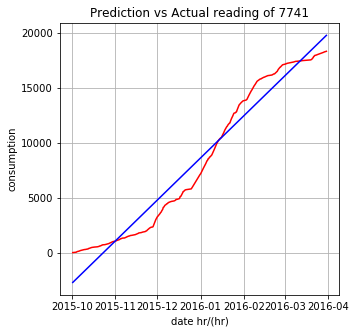

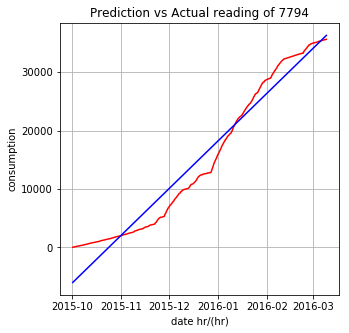

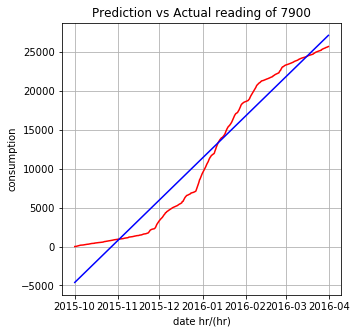

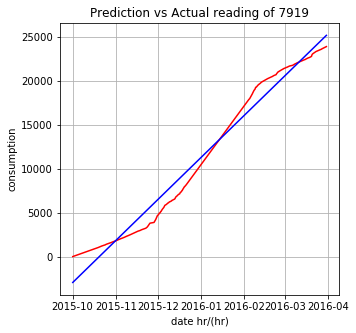

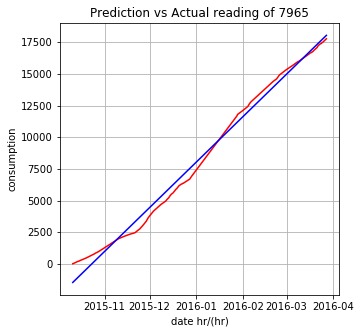

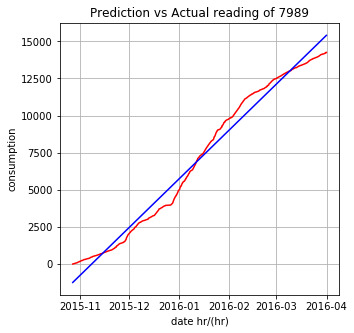

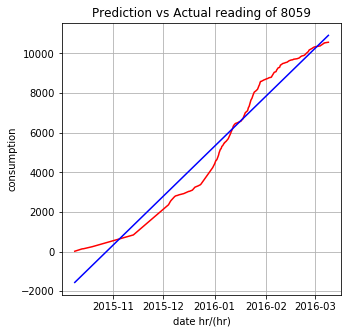

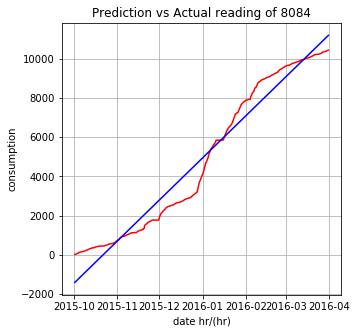

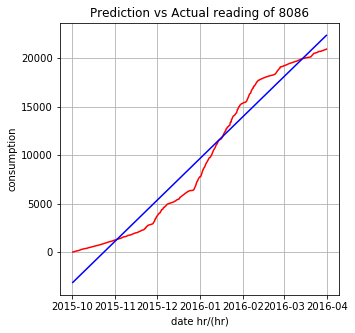

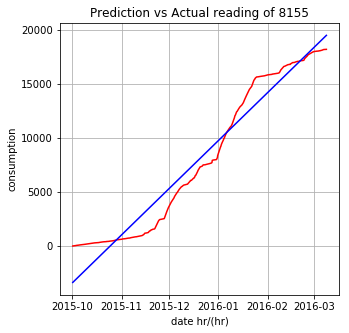

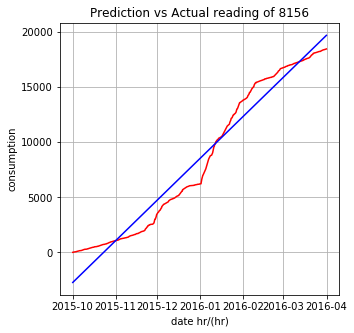

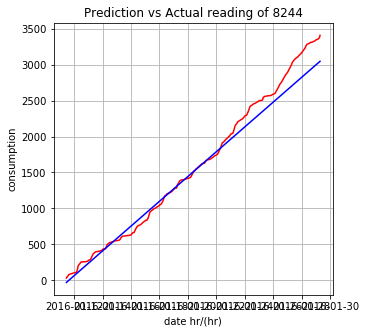

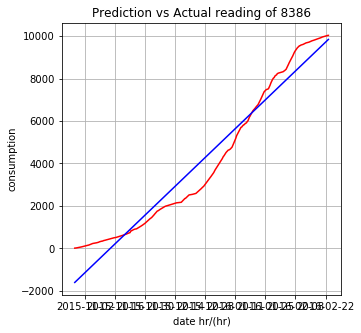

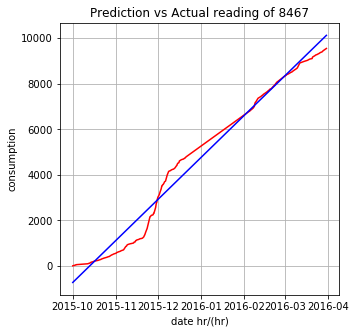

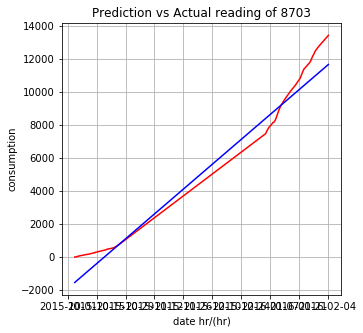

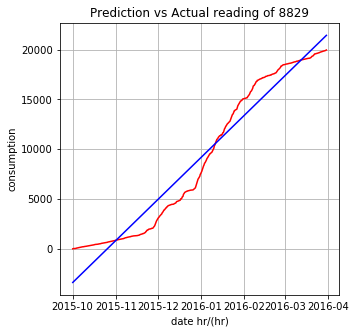

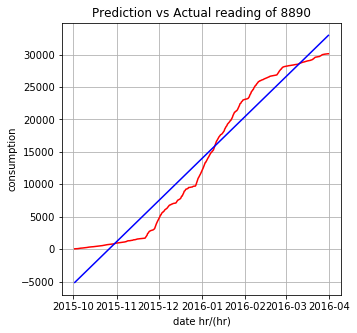

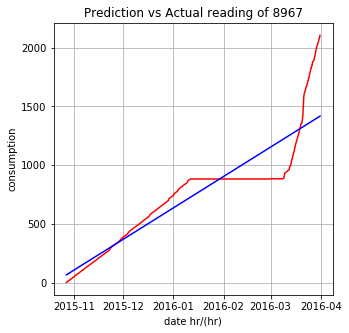

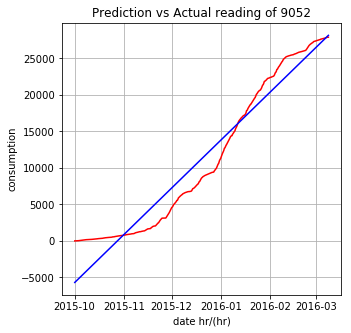

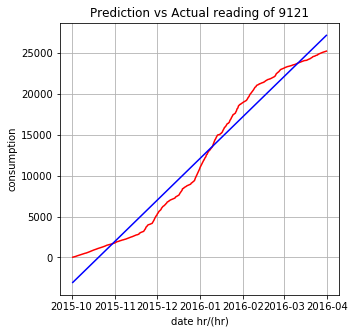

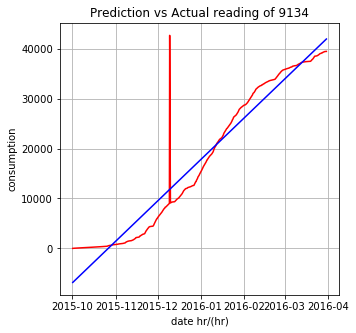

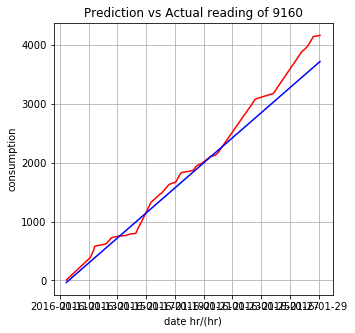

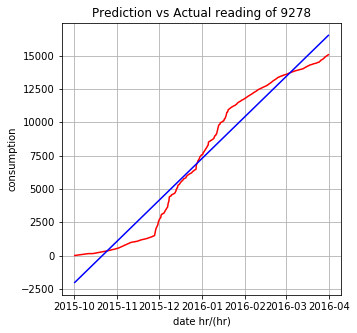

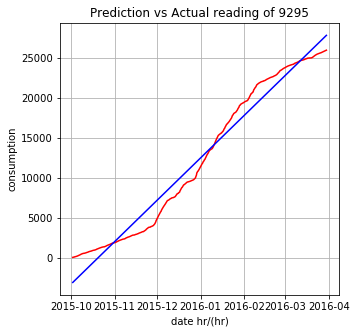

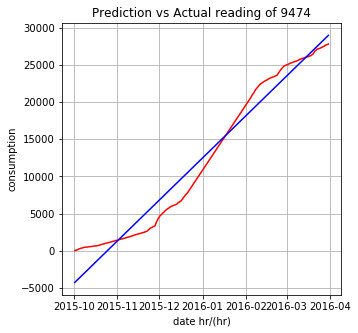

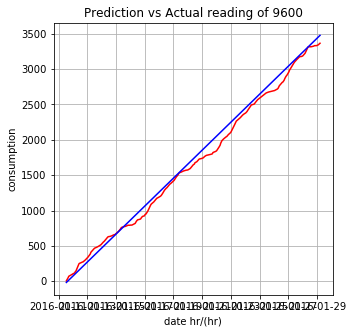

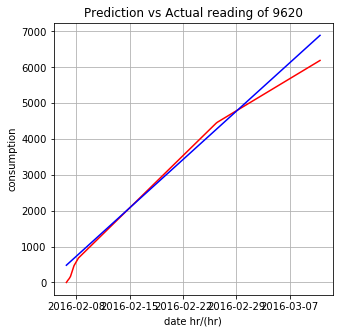

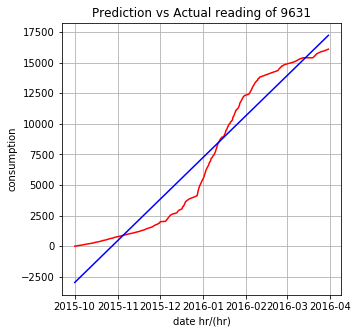

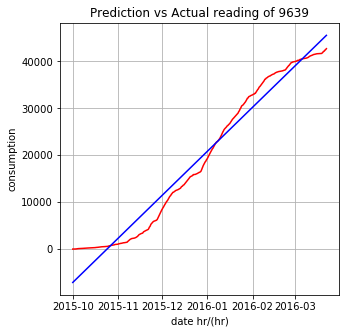

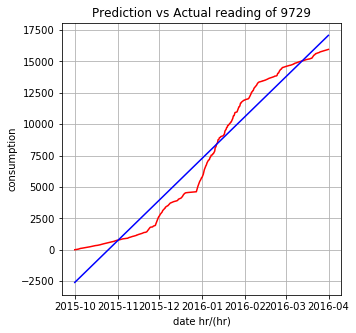

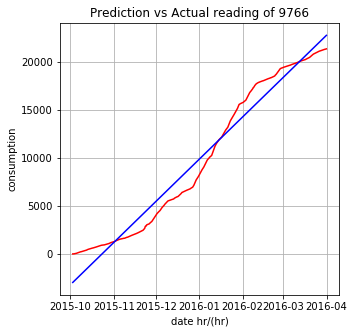

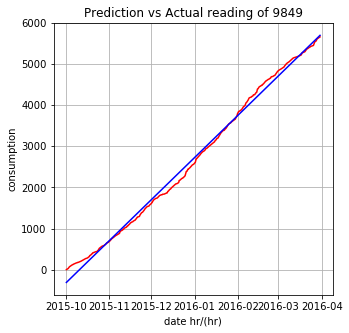

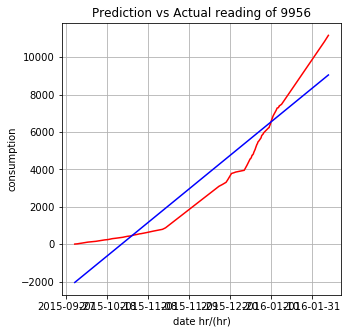

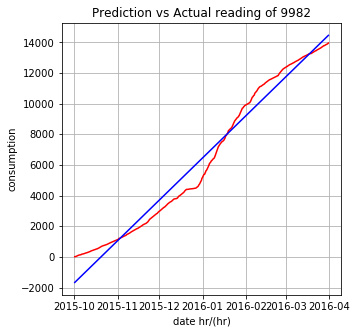

In [99]:
P_array=[];
score=[];
decre_index=0;
id_list1=[]

for index,item in enumerate(id_list):
    
    #data_temp=data_temp.append(normed_gas_hr[normed_gas_hr['dataid']==item]);
    X_temp=normed_gas_hr[normed_gas_hr['dataid']==item][['localminute']];
    Y_temp=normed_gas_hr[normed_gas_hr['dataid']==item][['meter_value']];
    if(item in id_lack):
        (X_train, X_test, Y_train, Y_test)=model_sel.train_test_split(X_temp,Y_temp,test_size=0.5);
    else:
        (X_train, X_test, Y_train, Y_test)=model_sel.train_test_split(X_temp,Y_temp,test_size=0.1);
    
#     data_temp=pd.DataFrame()
#     cor_list=gas_cor[gas_cor['HH1']==item];
#     cor_list=cor_list[cor_list['corr']>1.0]['HH2'];
    if(item in id_lack):
        X_train=X_train.append(normed_gas_hr_cp[normed_gas_hr_cp['dataid']==item][['localminute']]);
        Y_train=Y_train.append(normed_gas_hr_cp[normed_gas_hr_cp['dataid']==item][['meter_value']]);
        
    if(len(X_temp)<10):
        P_array.append('not enough data');
        score.append('not enough data')
    else:
        LR=lm.LinearRegression();
        predictor=LR.fit(X_train,Y_train);
        P_array.append(predictor)
        score.append(P_array[index].score(X_test,Y_test));
        predicted=P_array[index].predict(X_test);

        X_test=X_test.localminute.map(lambda x: dt.timedelta(hours=x)+min_time);
        result=pd.DataFrame(columns=['localminute','actual_reading','predicted_reading']);
        result['localminute']=X_test;
        result['actual_reading']=Y_test;
        result['predicted_reading']=predicted;
        result=result.sort_values(by='localminute');
        t='Prediction vs Actual reading of '+str(item)
        fig=plt.figure(figsize=(5,5));
        plt.plot(result.localminute,result.actual_reading,'r',result.localminute,result.predicted_reading,'b');
        plt.xlabel('date hr/(hr)');
        plt.ylabel('consumption');
        plt.title(t,loc='center');
        plt.grid();
        plt.show();

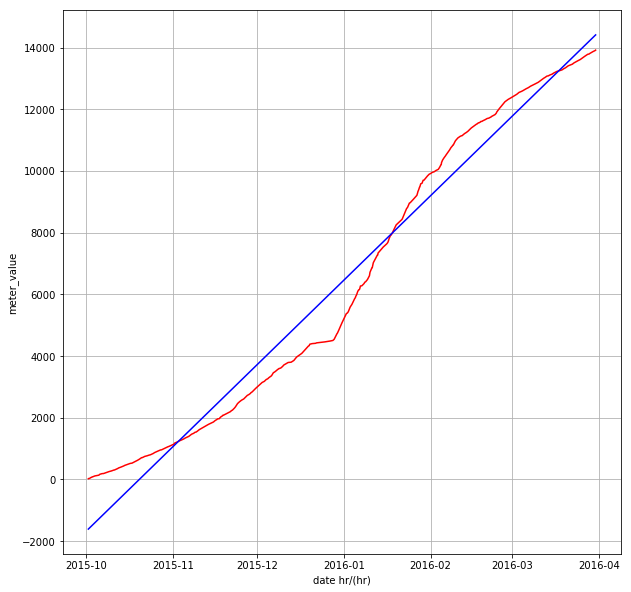

ValueError: ordinal must be >= 1

In [97]:
fig=plt.figure(figsize=(10,10));
plt.plot(result.localminute,result.actual_reading,'r',result.localminute,result.predicted_reading,'b');
plt.xlabel('date hr/(hr)');
plt.ylabel('meter_value'),
plt.grid();
plt.show();
fig=plt.figure(figsize=(10,10));
plt.scatter(result.actual_reading.tolist(),result.predicted_reading.tolist());
plt.scatter(result.localminute.tolist(),result.predicted_reading.tolist());
plt.xlabel('date hr/(hr)');
plt.ylabel('meter_value'),
plt.grid();
plt.show();

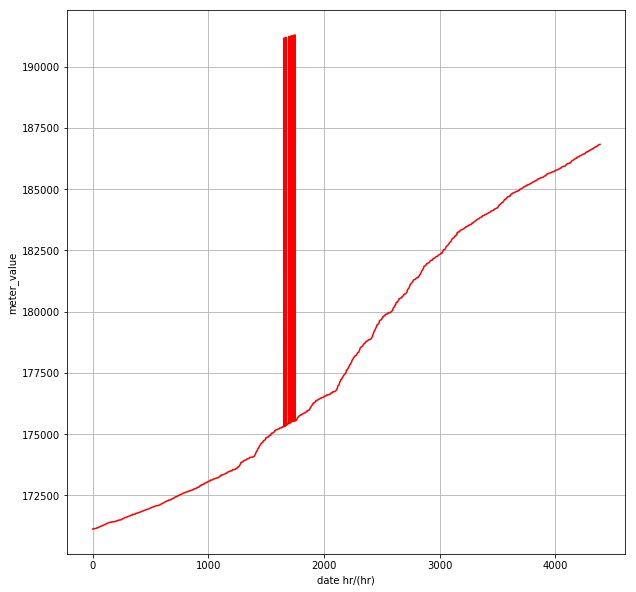

In [107]:
a=gas_hr[gas_hr['dataid']==2449];
fig=plt.figure(figsize=(10,10));
plt.plot(a.localminute,a.meter_value,'r');
plt.xlabel('date hr/(hr)');
plt.ylabel('meter_value'),
plt.grid();
plt.show();

In [110]:
a[1650:1700]

,localminute,dataid,meter_value
177599,1650.0,2449,175300
177600,1651.0,2449,175300
177601,1652.0,2449,175314
177602,1653.0,2449,191164
177603,1654.0,2449,191164
177604,1655.0,2449,191164
177605,1656.0,2449,191164
177606,1657.0,2449,175316
177607,1658.0,2449,175316
177608,1659.0,2449,175316
